## Modelling - ML

The goal for our work is to not only train a model to identify toxic comments, but to do so while reducing bias.
Bias in this task can be viewed as the situation where certain identies such as 'Black', 'Muslim', 'Gay' e.t.c, begin triggering toxic classification for comments they are in, even when the comment is actually positive. This is a key issue in toxic comment classification. 

The goal of the [jigsaw unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data) Kaggle challenge was to reduce this bias via a newly developed submetric which we have defined below.

**Note: The goal of the model is simply to predict the toxicity score of a model.** 

The bias weighted ROC metric below is calulated by taking segmenting the the dataset into identity subgroups by using the provided identity labels and then calculating the subgroup metrics.

In this notebook we have trained some baseline models which we will use as a baseline to compare our neural network against. 

### Metrics:

In addition to accuracy we will observe the below metrics for our models

#### Overall ROC-AUC:

This is the standard ROC-AUC for the full evaluation set. In other words this is the area under the Reciever Operating Characteristic curve. It compares the true positive and false positive rates of a binary model.

#### Subgroup ROC-AUC:

Here, we restrict the data set to only the examples that mention the specific identity subgroup. A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.

#### BPSN AUC:

BPSN (Background Positive, Subgroup Negative) AUC: Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.

#### BNSP AUC:

BNSP (Background Negative, Subgroup Positive) AUC: Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.


#### Generalized Mean of Bias AUCs
To combine the per-identity Bias AUCs into one overall measure, we calculate their generalized mean as defined below:

$M_p(m_s) = \left(\frac{1}{N} \sum_{s=1}^{N} m_s^p\right)^\frac{1}{p}$

Where:

$M_p$ = the $p$th power-mean function

$m_s$ = the bias metric $m$ calulated for subgroup $s$

$N$ = number of identity subgroups

For this competition, JigsawAI use a p value of -5 to encourage competitors to improve the model for the identity subgroups with the lowest model performance.

### Final Metric
We combine the overall AUC with the generalized mean of the Bias AUCs to calculate the final model score:

$score = w_0 AUC_{overall} + \sum_{a=1}^{A} w_a M_p(m_{s,a})$

$A$ = number of submetrics (3)

$m_{s,a}$ = bias metric for identity subgroup $s$ using submetric $a$

$w_a$ = $a$ weighting for the relative importance of each submetric; all four $w$ values set to 0.25


### Process:

#### Classical ML models
This is primarily an NLP task, our X feature matrix will be based off the text from online comments. We have defined a pre-processing pipeline in the 'preprocessing.ipynb' notebook to use for our our ML classifiers and a seperate pre-processing pipeline for the neural network models we are planning on training.

From the classic ML classifer models, we intend to use the following models - our base word embedding technique will be TF-IDF: 

   * Logistic Regression
   * SVM
   * Random Forest
 
   
We will carry out hyperparameter optimization for each model and calculate the metrics for each.

#### Neural Networks
*see NN_model.ipynb*

We will also train a neural network to answer this problem. We will start with a basic LSTM model which will be made of:
    
   * LSTM layers to read through the data
   * Dense layers
   * Output layer using sigmoid for the classes
   
We will then seek to improve this LSTM by creating a Bidrectional LSTM (BiLSTM) which we believe will improve accuracy by reading input sequences in both directions. If time allows we will also attempt to include a simple attention mechanism.

The NN models will use Glove 840B 300d word embeddings. 


In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import contractions
tqdm.pandas()
import gc
import operator
pd.options.display.float_format = '{:,.3f}'.format

import warnings
warnings.filterwarnings('ignore')

## Stage 1: Apply pre-processing to text

In [2]:
# Load train_data
train_df = pd.read_csv('data/train_clean.csv')

# Load in test data
test_df = pd.read_csv('data/test_clean.csv')

In [3]:
test_df.rename({'toxicity':'target'}, axis=1, inplace=1)

In [5]:
# Drop the unneeded columns
train_df = train_df.iloc[:,1:]
test_df = test_df.iloc[:,1:]

In [6]:
# In this cell we define the function that pre-processes our text

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import contractions
import string

def text_cleaner(df, col_name, clean_col_name):
    '''
    Text pre-processing pipeline, we lemmatize words, expand contractions, remove common stop words, apply lower case,
    tokenize, and delete punctuation. All functions use apply and list comprehension for speed benefit.
   
    INPUT:
    df = name of dataframe
    col_name = name of column to pre-process
    clean_col_name = name of new cleaned_column
   
    OUTPUT:
    None - changes are made directly to dataframe
    
    '''

    # Lemmatize helper functions
    # Lemmatize nouns
    def lemmatize_text_noun(text):
        return [lemmatizer.lemmatize(w, pos='n') for w in text]
    
    # Lemmatize verbs
    def lemmatize_text_verb(text):
        return [lemmatizer.lemmatize(w, pos='v') for w in text]
    # Lemmatize adjectives
    def lemmatize_text_adj(text):
        return [lemmatizer.lemmatize(w, pos='a') for w in text]

    # Lemmatize adverbs
    def lemmatize_text_adv(text):
        return [lemmatizer.lemmatize(w, pos='r') for w in text]
    
    # Expand contraction method
    def contraction_expand(text):
        return contractions.fix(text)
    
    # To lower case.
    df[clean_col_name] = df[col_name].apply(lambda x: x.lower())
    
    # Expand contractions
    df[clean_col_name] = df[clean_col_name].apply(lambda x: contraction_expand(x))
    
    #Tokenize:
    tokenizer = TweetTokenizer(reduce_len=True)
    df[clean_col_name] = df[clean_col_name].apply(lambda x: tokenizer.tokenize(x))
   
    
    #Remove Stop words
    stop_words = stopwords.words('english')
    df[clean_col_name] = df[clean_col_name].apply(lambda x: [item for item in x if item not in stop_words])
    
    #Delete punctuation
    punc_table = str.maketrans('', '', string.punctuation)
    df[clean_col_name] = df[clean_col_name].apply(lambda x: [item.translate(punc_table) for item in x])
    
    # LEMMATIZATION
    lemmatizer = WordNetLemmatizer()
    
    df[clean_col_name] = df[clean_col_name].apply(lemmatize_text_noun)
    df[clean_col_name] = df[clean_col_name].apply(lemmatize_text_verb)
    df[clean_col_name] = df[clean_col_name].apply(lemmatize_text_adj)
    df[clean_col_name] = df[clean_col_name].apply(lemmatize_text_adv)
    
    
    return None


def detokenizer(df, col_name):
    detokenizer = TreebankWordDetokenizer()
    df[col_name+'_detokenize'] = df[col_name].apply(lambda x: detokenizer.detokenize(x))
    
    return None

In [7]:
%%time
# Run the cleaner func on train data
text_cleaner(train_df, 'comment_text', 'comment_text_clean')

CPU times: user 19min 18s, sys: 8.28 s, total: 19min 26s
Wall time: 19min 30s


In [ ]:
%%time 
# Run the same cleaner on the training data
text_cleaner(test_df, 'comment_text', 'comment_text_clean')

In [9]:
%%time
detokenizer(train_df,'comment_text_clean')

CPU times: user 3min 34s, sys: 803 ms, total: 3min 35s
Wall time: 3min 37s


In [10]:
%%time
# detokenize the test data
detokenizer(test_df, 'comment_text_clean')

CPU times: user 23.9 s, sys: 194 ms, total: 24.1 s
Wall time: 24.4 s


## Stage 2: Modelling

The data has been pre-processed for our models. We can now begin model training.

We have a seperate test dataset that will be kept aside for testing only once we have an ideal model. For hyperparameter optimizing we will use Scikit-learn's GridSearchCV. 

After we have fitted a model and predicted results, we can then append the predictions to the dataframe and calculate the subgroup AUCs and the final weighted metric . 

#### Defining subgroup AUC metrics

In [11]:
from sklearn import metrics
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive


# These calculations have been provided by Jigsaw AI for scoring based on the metrics of the kaggle competition
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation

# They work by filtering the relevant dataframe into specific subgroups and using the roc_auc_score metric from sklearn.

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df.loc[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df.loc[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df.loc[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df.loc[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset.loc[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)



In [12]:
# These calculations have been provided by Jigsaw AI for scoring based on the metrics of the kaggle competition
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation

# They work by filtering the relevant dataframe into specific subgroups and using the roc_auc_score metric from sklearn.

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    


### Logistic Regression

We will use Grid Search Cross validation to optimize our hyperparameters on the training set. We will then fit the best estimator and then predict on the test set and calculate relevent metrics.

Because the subgroup ROCs are calculated post prediction and require predictions to be appended to a dataframe, we cannot actually pass the metrics into the scoring function of scikit-learn's gridsearchCV(). Instead we will just test the models on accuracy and total ROC-AUC and then refitting the grid-search on the model with the best ROC-AUC as a proxy.

In [19]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
#no scaling data is already transformed

# Instantiate the tokenizer to use in the vectorizer
tweet_tokenizer = TweetTokenizer(reduce_len=True)

# Instantiate the vectorizer, we will pass in the TweetTokenizer() from nltk 
tfid_vec_2 = TfidfVectorizer(lowercase=False, tokenizer = tweet_tokenizer.tokenize)

# define pipeline
pipeline = Pipeline([('tf-idf', tfid_vec_2), 
                     ('model', SVC())])



CPU times: user 1.65 ms, sys: 3.6 ms, total: 5.25 ms
Wall time: 8.3 ms


In [15]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# Define scoring functions
scorers = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}


In [ ]:
# define parameters
param_grid_log = [{'model': [LogisticRegression()], 'tf-idf': [tfid_vec_2], 
                   'model__penalty': ['l1', 'l2'],
                   'model__C': [.001, 0.01, 0.1, 1, 10, 100]}]

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score, i.e it finds the params that gives the best scores
# then refits using the ones that give the best AUC. 
grid_log = GridSearchCV(pipeline, param_grid_log, cv=5, scoring=scorers, refit='AUC', 
                        return_train_score=True, n_jobs=-1)

fittedgrid_log = grid_log.fit(train_df['comment_text_clean_detokenize'], train_df['target'])

In [ ]:
from sklearn.externals import joblib
# Save best estimator to file
joblib.dump(fittedgrid.best_estimator_, 'saved_models/best_log_reg.pkl')

In [50]:
#Run this to load the model if required
from sklearn.externals import joblib
from joblib import load
fittedgrid_log = load('saved_models/best_log_reg.pkl')

In [334]:
# Get accuracy scores
train_accuracy_log = fittedgrid_log.score(train_df['comment_text_clean_detokenize'], y_train)
test_accuracy_log = fittedgrid_log.score(test_df['comment_text_clean_detokenize'], y_test)

In [378]:
# predict train and test values
y_train_pred = fittedgrid_log.predict(train_df['comment_text_clean_detokenize'])
y_test_pred = fittedgrid_log.predict(test_df['comment_text_clean_detokenize'])

# Get the actual probabilities
y_train_pred_prob_log = fittedgrid_log.predict_proba(train_df['comment_text_clean_detokenize'])
y_test_pred_prob_log = fittedgrid_log.predict_proba(test_df['comment_text_clean_detokenize'])

In [337]:
# Confusion Matrix and Classification Report, we want to store the F1 Score.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# store the precision, recall, and f1 score for later and print the classification report
log_precision = precision_score(y_test, y_test_pred)
log_recall = recall_score(y_test, y_test_pred)
log_f1 = f1_score(y_test, y_test_pred)

print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.97    179192
           1       0.76      0.50      0.60     15448

    accuracy                           0.95    194640
   macro avg       0.86      0.74      0.79    194640
weighted avg       0.94      0.95      0.94    194640



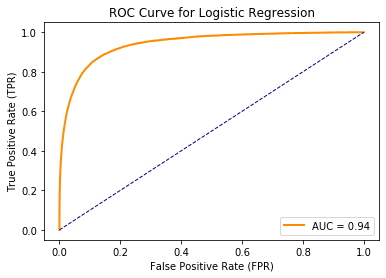

Area under curve (AUC):0.9408323249419588


In [379]:
# Lets plot out the regular ROC curve - code taken from Model-Evaluation class. 
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_test_pred_prob_log[:,1])
roc_auc = roc_auc_score(y_test, y_test_pred_prob_log[:,1])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')

In [338]:
# Append preds and probabilities to train and valid dfs
train_df['Prediction_log'] = y_train_pred
train_df['Prediction_probability_log'] = y_train_pred_prob[:, 1]
test_df['Prediction_log'] = y_test_pred
test_df['Prediction_probability_log'] = y_test_pred_prob[:, 1]

In [339]:
# Identity columns used to calculate subgroup AUC
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']



In [340]:
for col in identity_columns + ['target']:
    train_df[col] = np.where(train_df[col] >= 0.5, True, False)
    test_df[col] = np.where(test_df[col] >= 0.5, True, False)

In [425]:
# Generate the AUC metrics 

# Set parameters for the logistic model 
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'

MODEL_NAME = 'Prediction_log'
TOXICITY_COLUMN = 'target'

# generate the subgroup bias dataframes for the logistic model
log_bias_metrics_df_train = compute_bias_metrics_for_model(train_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
log_final_metric_train = get_final_metric(log_bias_metrics_df_train, calculate_overall_auc(train_df, MODEL_NAME))

# generate the final metrics 
log_bias_metrics_df_test = compute_bias_metrics_for_model(test_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
log_final_metric_test = get_final_metric(log_bias_metrics_df_test, calculate_overall_auc(test_df, MODEL_NAME))

In [426]:
log_bias_metrics_df_test

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,1065,0.655,0.682,0.714
5,muslim,2040,0.665,0.719,0.689
3,christian,4226,0.667,0.739,0.671
4,jewish,835,0.678,0.719,0.700
6,black,1519,0.683,0.687,0.737
7,white,2452,0.687,0.701,0.728
0,male,4386,0.713,0.729,0.726
8,psychiatric_or_mental_illness,511,0.715,0.722,0.734
1,female,5155,0.719,0.734,0.727


In [413]:
print(f'train_accuracy:{train_accuracy}')
print(f'train final weighted AUC:{get_final_metric(log_bias_metrics_df_train, calculate_overall_auc(train_df, MODEL_NAME))}')
print(f'test_accuracy:{test_accuracy}')
print(f'test final weighted AUC::{get_final_metric(log_bias_metrics_df_test, calculate_overall_auc(test_df, MODEL_NAME))}')


train_accuracy:0.9443495778652693
train final weighted AUC:0.7197198017038468
test_accuracy:0.9441789971228935
test final weighted AUC::0.7126513014416012


#### Model Evaluation:

The logistic regression performed well on pure accuracy, with a train accuracy of 95.38% and 94.96% test accuracy. What is also positive to see is that our hyperparameter optimization has led to a model which does not overfit excessively. 

However when we look at the weighted subgroup AUC metric, the 71.9% train score and 71.5% test score show that the model did have a tendency towards biased predictions for certain subgroup. In comparison, the benchmark CNN that was provided had a weighted AUC score of 88.35% albeit just on a validation set. For example we can see that for the 'black' identity BPSN AUC was relatively low, suggesting the model is likely overweighting mentions of the 'black' identity with toxicity. 

In addition, we can also see that the recall score for the positive class was low. We believe that this is due to the large class imbalance within the data set, where only 8% of cases were toxic. As a result, the model had relativley little information to train on for actual toxic examples, lessening its ability to identify all cases of toxicity. This will likely be the case for all the models trained here and is something we would look to address as part of further study.



--------------

### XGBoost

We will now carry out a similar process with the XGBoost classifier,

#### Grid searching on a subset of data

Given the length of time taken to grid search using XGBoost, we will run a gridsearch on a subset of our dataset by taking a new train test split. We will then use the results there as a proxy for the optimal parameters for our full dataset.  

In [ ]:
from sklearn.model_selection import train_test_split
# Create a new split of the training dataframe to use for this reduced test. 
# we will not need the remainder. We will take 1/4 of the total data set
remainder, reduced_df = train_test_split(train_df, test_size=0.25, stratify=train_df['target'], random_state=1)

In [306]:
%%time
from xgboost import XGBClassifier

# Grid search applies tfid_vec_2 to all models. XGB is a boosting method so the idea is to train a sequence of weak models.
# we are using a decision tree implementation so this means we will train a sequence of low depth trees.
# one of the key hyperparameters is therefore learning rate. 
# min_child_weight controls what the minimum weight a child can have to classify it as a final node. Higher values mean
# more conservative decision boundaries
# gamma sets a minimum loss reduction amount. If drawing a class boundary at a certain point does not breach this threshold
# the model will not draw the boundary.

param_grid_xgb = [{'model': [XGBClassifier()], 'tf-idf': [tfid_vec_2],
                    "model__learning_rate"    : [ 0.15, 0.30, 0.45 ] , #default 0.3
                     "model__min_child_weight" : [ 1, 3, 7 ], #1 is default
                     "model__gamma"            : [ 0.0, 0.2, 0.4 ], #default is 0 
                      }]

reduced_grid_xgb = GridSearchCV(pipeline, param_grid_xgb, scoring=scorers, cv=3, refit='AUC',
                       return_train_score=True, n_jobs=-1, verbose=10)

reduced_grid_xgb = reduced_grid_xgb.fit(reduced_df['comment_text_clean_detokenize'], reduced_df['target'])

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 71.7min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed: 100.7min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 104.4min finished


CPU times: user 14min 39s, sys: 1min 17s, total: 15min 56s
Wall time: 1h 48min 25s


In [309]:
# Gives the model with the best AUC score
reduced_grid_xgb.best_estimator_

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0.4,
                               learning_rate=0.45, max_delta_step=0,
                               max

We can see that from our gridsearch of the subset of data, the best model had max_depth of 3, min child weight of 3, gamma of 0.4 and a learning rate of 0.45. We will use this information to train a XGB model on the full dataset.

In [311]:
# what is the best AUC score
reduced_grid_xgb.best_score_

0.9063757091545201

#### Fitting model on full dataset

In [321]:
%%time
#as we aren't using gridsearch, we will need to directly transform the train and test features using the 
#tfidf vectorizer
X_train = tfid_vec_2.transform(train_df['comment_text_clean_detokenize'])
X_test = tfid_vec_2.transform(test_df['comment_text_clean_detokenize'])

#instantiate XGB Classfier with parameters learned from earlier
XGB_model = XGBClassifier(max_depth =3, learning_rate=0.45, min_child_weight=3, gamma=0.4)
# Fit model on training set
XGB_model.fit(X_train, y_train)

CPU times: user 14min 15s, sys: 9.19 s, total: 14min 24s
Wall time: 14min 38s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,
              learning_rate=0.45, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [322]:
# Save best estimator to file
joblib.dump(XGB_model, 'saved_models/best_XGB.pkl')

['saved_models/best_XGB.pkl']

In [333]:
# Get scores
train_accuracy_xgb = XGB_model.score(X_train, y_train)
test_accuracy_xgb = XGB_model.score(X_test, y_test)

In [375]:
# predict train and test values
y_train_pred = XGB_model.predict(X_train)
y_test_pred = XGB_model.predict(X_test)

y_train_pred_prob_xgb = XGB_model.predict_proba(X_train)
y_test_pred_prob_xgb = XGB_model.predict_proba(X_test)

In [326]:
# store the precision, recall, and f1 score for later and print the classification report
xgb_precision = precision_score(y_test, y_test_pred)
xgb_recall = recall_score(y_test, y_test_pred)
xgb_f1 = f1_score(y_test, y_test_pred)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    179192
           1       0.79      0.41      0.54     15448

    accuracy                           0.94    194640
   macro avg       0.87      0.70      0.75    194640
weighted avg       0.94      0.94      0.94    194640



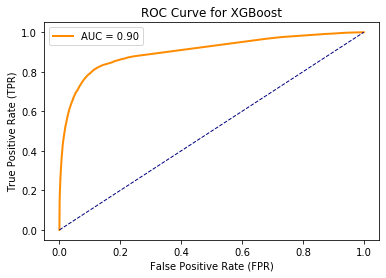

Area under curve (AUC):0.9031525355668136


In [377]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_test_pred_prob_xgb[:,1])
roc_auc = roc_auc_score(y_test, y_test_pred_prob_xgb[:,1])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')


In [327]:
# Append preds and probabilities to train and valid dfs


train_df['Prediction_xgb'] = y_train_pred
train_df['Prediction_probability_xgb'] = y_train_pred_prob[:, 1]
test_df['Prediction_xgb'] = y_test_pred
test_df['Prediction_probability_xgb'] = y_test_pred_prob[:, 1]

In [414]:
# Generate the AUC metrics 

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'

MODEL_NAME = 'Prediction_xgb'
TOXICITY_COLUMN = 'target'

xgb_bias_metrics_df_train = compute_bias_metrics_for_model(train_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
xgb_final_metric_train = get_final_metric(xgb_bias_metrics_df_train, calculate_overall_auc(train_df, MODEL_NAME))

xgb_bias_metrics_df_test = compute_bias_metrics_for_model(test_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
xgb_final_metric_test = get_final_metric(xgb_bias_metrics_df_test, calculate_overall_auc(test_df, MODEL_NAME))

In [416]:
print(f'train_accuracy:{train_accuracy}')
print(f'train final weighted AUC:{get_final_metric(xgb_bias_metrics_df_train, calculate_overall_auc(train_df, MODEL_NAME))}')
print(f'test_accuracy:{test_accuracy}')
print(f'test final weighted AUC::{get_final_metric(xgb_bias_metrics_df_test, calculate_overall_auc(test_df, MODEL_NAME))}')

train_accuracy:0.9443495778652693
train final weighted AUC:0.6679029973304209
test_accuracy:0.9441789971228935
test final weighted AUC::0.666201450252322


In [418]:
xgb_bias_metrics_df_test

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
6,black,1519,0.616,0.672,0.645
3,christian,4226,0.618,0.702,0.617
4,jewish,835,0.619,0.693,0.626
8,psychiatric_or_mental_illness,511,0.624,0.687,0.637
2,homosexual_gay_or_lesbian,1065,0.631,0.681,0.650
5,muslim,2040,0.632,0.690,0.643
7,white,2452,0.651,0.677,0.674
0,male,4386,0.656,0.696,0.661
1,female,5155,0.657,0.698,0.660


#### Model Evaluation
In terms of pure accuracy the XGBoost classifier performed as well as the logistic regression. However when we calculate the weighted AUC metric the model has performed worse at 66.6% on the test data. Looking at the subgroup AUC dataframe suggests a general weakness accross all identity subgroups. 

Recall was weaker at 0.41 and so was the overall AUC at 90% which is another reason for the weaker weighted AUC metric.

This may be as a result of us having to carry out hyperparameter optimization on just a subset of the data, but also not being able to explore as many parameter combinations. With additional computing power we would be able to do a more exhaustive search ont he full dataset. 

--------

### Random Forest

For our final model we will try the Random Forest Classifier which is an ensemble method. It is based on the Decision Tree model, only the Random Forest works by fitting on random sub samples of the data (with replacement), which is known as 'bagging'. A voting algorithm is then applied on the results of each of the trees to determine the final class of the data point. The aim of Random Forest is to train a series of overfit models and then average out the results via voting to get better results. The main hyperparemeter we will optimize for is the number of decision trees to use and the max depth of the trees. 


#### Grid Search on a subset of data

Given the length of time taken to grid search on the Random Forest Classifier, we will run a gridsearch on a subset of our dataset by taking a new train test split. We will then use the results there as a proxy for the optimal parameters for our full dataset. We will use the same train_test split as used for the XGB subset search. 

In [60]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Note, most of the time here actually comes from the application of the tfid vectorizer to each fold of the data
# Random forest itself takes ~5minutes to run on the vectorized data.

# We control the model max depth 
param_grid_RF = {'model': [RandomForestClassifier()], 'tf-idf': [tfid_vec_2], 
                 'model__n_estimators': [10,50,100],
                 'model__max_depth': [100, 500, 1000, 5000],
             }
reduced_grid_RF = GridSearchCV(pipeline, param_grid_RF, scoring=scorers, cv=3, refit='AUC',
                       return_train_score=True, n_jobs=-1, verbose = 10)

reduced_grid_RF = reduced_grid_RF.fit(reduced_df['comment_text_clean_detokenize'], reduced_df['target'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 78.8min remaining: 34.7min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 113.6min remaining: 27.4min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 132.4min remaining: 12.0min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 165.0min finished


CPU times: user 50min 44s, sys: 12.9 s, total: 50min 57s
Wall time: 3h 35min 49s


In [61]:
# check the best estimator parameters
reduced_grid_RF.best_estimator_

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=1000,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                               

In [62]:
# gives the best AUC score
reduced_grid_RF.best_score_

0.9230210872062684

In [ ]:
#reduced_grid_RF.cv_results_

The above test has suggested that in terms of hyperparameters, we should look at a model that has n_estimators around 100 or above, and max_depth of around 1000. We will use this as a guide for our grid search. 

#### Fitting the model on the full dataset
Now that we have a good idea of optimal parameters, we will apply these parameters on the full dataset.

In [110]:
# We need to transform the data.
X_train = tfid_vec_2.transform(train_df['comment_text_clean_detokenize'])
X_test = tfid_vec_2.transform(test_df['comment_text_clean_detokenize'])

# Instantiate the model with correct parameters and fit.
RF_model = RandomForestClassifier(n_estimators = 100, max_depth = 1000)
RF_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1000, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [116]:
%%time
rf_test_accuracy = RF_model.score(X_test, y_test)


CPU times: user 1min 20s, sys: 3.61 s, total: 1min 24s
Wall time: 1min 26s


In [117]:
rf_test_accuracy

0.9417591450883682

In [119]:
# Save best estimator to file
joblib.dump(RF_model, 'saved_models/best_RF.pkl')

['saved_models/best_RF.pkl']

In [370]:
# predict train and test values
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)

y_train_pred_prob_rf = RF_model.predict_proba(X_train)
y_test_pred_prob_rf = RF_model.predict_proba(X_test)

In [372]:
y_test_pred_prob_rf

array([[0.96265644, 0.03734356],
       [0.97665037, 0.02334963],
       [0.97868673, 0.02131327],
       ...,
       [0.46485893, 0.53514107],
       [0.88846968, 0.11153032],
       [0.96707338, 0.03292662]])

In [295]:
# store the precision, recall, and f1 score for later and print the classification report
rf_precision = precision_score(y_test, y_test_pred)
rf_recall = recall_score(y_test, y_test_pred)
rf_f1 = f1_score(y_test, y_test_pred)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    179192
           1       0.83      0.34      0.48     15448

    accuracy                           0.94    194640
   macro avg       0.89      0.67      0.72    194640
weighted avg       0.94      0.94      0.93    194640



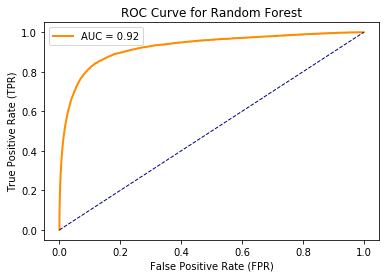

Area under curve (AUC):0.9247063596820333


In [419]:
# Lets plot the standard ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_test_pred_prob_rf[:,1])
roc_auc = roc_auc_score(y_test, y_test_pred_prob_rf[:,1])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')


In [291]:
# Identity columns used to calculate subgroup AUC
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [292]:
for col in identity_columns + ['target']:
    train_df[col] = np.where(train_df[col] >= 0.5, True, False)
    test_df[col] = np.where(test_df[col] >= 0.5, True, False)

In [293]:
# Append preds and probabilities to train and valid dfs
train_df['Prediction_RF'] = y_train_pred
train_df['Prediction_probability_RF'] = y_train_pred_prob[:, 1]
test_df['Prediction_RF'] = y_test_pred
test_df['Prediction_probability_RF'] = y_test_pred_prob[:, 1]

In [294]:
# Generate the AUC metrics 

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'

MODEL_NAME = 'Prediction_RF'
TOXICITY_COLUMN = 'target'

rf_bias_metrics_df_train = compute_bias_metrics_for_model(train_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
rf_final_metric_train = get_final_metric(rf_bias_metrics_df_train, calculate_overall_auc(train_df, MODEL_NAME))

rf_bias_metrics_df_test = compute_bias_metrics_for_model(test_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
rf_final_metric_test = get_final_metric(rf_bias_metrics_df_test, calculate_overall_auc(test_df, MODEL_NAME))

In [296]:
rf_bias_metrics_df_test

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
6,black,1519,0.535805,0.671200,0.534692
3,christian,4226,0.538518,0.671294,0.536449
4,jewish,835,0.542044,0.668454,0.540397
5,muslim,2040,0.542836,0.672161,0.540382
2,homosexual_gay_or_lesbian,1065,0.546340,0.669129,0.545196
7,white,2452,0.556286,0.671977,0.555543
1,female,5155,0.573352,0.671357,0.572037
8,psychiatric_or_mental_illness,511,0.584684,0.664368,0.586552
0,male,4386,0.585907,0.670266,0.584965


In [297]:
rf_final_metric_test

0.6108032567341172

In [ ]:
print(f'train_accuracy:{train_accuracy}')
print(f'train weighted AUC:{rf_final_metric_train}')
print(f'test_accuracy:{test_accuracy}')
print(f'test weighted AUC::{rf_final_metric_test}')


#### Model Evaluation
Of the classical models the Random Forest was by far the weakest in terms of the final weighted AUC metric. It generally did poorly accross all the identity subgroups. In addition to this, it had very poor recall on the test set, implying that the model was failing to identify many cases of toxic commentary.

--------

### Comparing Model performance

Now that we have trained three seperate models which have been shown to deliver strong performance in text classification tasks in the past let us take the time to compare them side-by-side and also discuss their short-comings in terms of reducing bias

In [ ]:
#Display the subgroup bias metrics tables for each model and then the final metrics for each model for test only
display(log_bias_metrics_df_test)
display(svm_bias_metrics_df_test)
display(rf_bias_metrics_df_test)

In [420]:
# Display final metrics for each model for test only.
print(f' Final metric for Logistic Regression: {log_final_metric_test}')
print(f' Final metric for XGB: {xgb_final_metric_test}')
print(f' Final metric for Random Forest: {rf_final_metric_test}')

 Final metric for Logistic Regression: 0.7126513014416012
 Final metric for XGB: 0.666201450252322
 Final metric for Random Forest: 0.6108032567341172


In [421]:
# NN model results taken from NN_model ipynb
NN_final_metric_test = 0.920
NN_precision_test = 0.754
NN_Recall_test = 0.628
NN_f1_test = 0.681
NN_accuracy_test = 0.953

In [422]:
data = {'Accuracy': [test_accuracy_log, test_accuracy_xgb, rf_test_accuracy, NN_accuracy_test ], 
        'Precision': [log_precision, xgb_precision, rf_precision, NN_precision_test ],
       'Recall': [log_recall, xgb_recall, rf_recall, NN_Recall_test], 'F1': [log_f1, xgb_f1, rf_f1, NN_f1_test ],
       'Final Bias Metric': [log_final_metric_test, xgb_final_metric_test, rf_final_metric_test, NN_final_metric_test ]}

results_df = pd.DataFrame(data, index=['Logistic', 'XGboost', 'Random Forest', 'LSTM'])

In [423]:
results_df

,Accuracy,Precision,Recall,F1,Final Bias Metric
Logistic,0.947,0.758,0.495,0.599,0.713
XGboost,0.944,0.785,0.408,0.537,0.666
Random Forest,0.942,0.826,0.338,0.479,0.611
LSTM,0.953,0.754,0.628,0.681,0.920


From the results we can see that our LSTM model has generally outperformed all three of the other models in the metrics selected. In particular we can see that the final bias metric, the weighted average of the subgroup AUCs, was significantly higher for the LSTM than the others at 0.92. This suggests that the LSTM model was better than the other models at minimising bias by not focussing on specific occurances of certain identy words when evaluating a particular comment. This fits in with our initial hypothesis and it is a positive result. 

#### Steps for further exploration:

All our models generally showed strong precision, suggesting that when they did classify something as toxic they were generally accurate. However we can see that recall was usually weak, suggesting that the model struggled to pick out all cases of toxicity. We believe this is highly likely to be due to the large class imbalance in the dataset where only ~8% of the data was classified as toxic. A natural first step would be to therefore re-run the model on a more balanced dataset. Another option would be to lower the threshold for toxicity, however this can come at the expense of precision.

We would also like to carry out a more exhaustive hyperparameter optimization exercise for our models. Unfortunately, it quickly became apparent that doing so on our current computing hardwarde was not feasible and cloud hardware was primarily used to train our LSTM. With access to more powerful hardware we would be able to better optmize our models.

For our LSTM model, we would definitely like to try further network structures, including potentially adding a further bi-directional layer or an attention mechanism. Attention mechanisms have been proven to be very effective in tasks where a model needs to focus in on specific areas of a sequence that containt he most relevant information and are core parts of many SotA NLP architectures. In addition with more time we would like to try out different glove embeddings and also process our text further to potentially increase the percentage of our vocabulary covered by the word embeddings.

-----

-------------

## Exploring the results of our ML models using eli5

Below we use the eli5 package to help interpret our results. We will do this using the logistic model we fit due to only certain sklearn classifiers being compatible. The logistic model was also the best performing of the three traditional ML models we have tested. Documentation on the TextExplainer can be found [here.](https://eli5.readthedocs.io/en/latest/_notebooks/text-explainer.html)

In [66]:
import eli5
from eli5.lime import TextExplainer

Using TensorFlow backend.


In [ ]:
# Load in log model
joblib.dump(fittedgrid.best_estimator_, 'saved_models/best_log_reg.pkl')

In [407]:
# Instantiate the lime TextExplainer model
text_model_log = TextExplainer(random_state=1)

#select a comment to investigate - because our model was trained on pre-processed data we need to use the pre-processed 
# text detokenized. You can change the index in the loc function to get different comments. 
text = test_df.loc[175957,'comment_text_clean_detokenize']

# Fit the Textexplainer using the the selected test and passing in the predict_proba function for our fitted logistic model.
text_model_log.fit(text, fittedgrid_log.predict_proba)
text_model_log.show_prediction(target_names=['Non-toxic', 'Toxic'])

The above example is a case of a comment which was originally labelled as 'Non-Toxic', but our model has labelled as 'Toxic'. We can see that the model has specifically highlighted the mentions of the word gay, lesbian, and transgender as key contributers to toxicity, which is the exact reason why these models have issues with bias against minority identities.  The original comment text is below. 

In [403]:
test_df.loc[175957, 'comment_text']

'I think your hearts in the right place but gay men and lesbians have no issues using the correctly gendered bathrooms. Sexual orientation and gender identity are two totally different things. A transgender person can be gay, lesbian, bi, straight or any other Sexual orientation.'